# Predict future sales

Requirements:
- numpy
- scipy
- matplotlib
- sklearn
- xgboost  (I used gpu version; with cpu version will be slightly different)
- pandas

## Overview

This notebook contains all EDA, tuning, plots, stacking. It was my working notebook, so it is messy. If you want to generate final submission, run accompanying notebook generate_submission.ipynb.

Up to now I am at leading position on the leaderboard with public score = 0.87966. To get this score I expoited a little data leak. It will be described in section on feature generation.

My hardware: i3, 8Gb RAM, gtx1060 (for gpu xgboost), SSD (I could not have done this without you, my dear).

Stucture and few comments:

1) EDA - nothing specific, advise you to jump to feature generation.

2) Feature extraction - month aggregation, category id, lagged features, text features, reduce train a bit, data leak and expanded mean encoding

3) Validation - train, test split generator. By the way local validation is completely useless. Std on xgb predictions may reach ~20% with some settings. I spent most of my time trying to make good validation, but 

4) Models. Each model have its own sections with tuning, oof predictions and test predictions
    - XGBoost on encoded features, magic features, lagged features
    - Linear regression on dimension reduced (Truncated SVD) text and one-hot-encoded features, magics

5) Stacking. Simple linear combination of above predictions.

tl;dr xgboost with magic feature, item_id frequences and lagged target for 1,2,3,6,12 month will alone give 0.8887 score.

### Libraries and general functions

In [1]:
from scipy.sparse import save_npz, load_npz, hstack, vstack
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import KFold
from functools import partial
import numpy as np
import itertools as it
import pandas as pd
import xgboost as xgb
import warnings
import time
import gc

Filter some annoying pandas warnings.

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
LOAD = True

In [4]:
def clip_month_counts(counts):
    """Results should be clipped to [0, 20] range"""
    return np.clip(counts, 0, 20)

In [5]:
def save_submit_results(test_id, test_counts, save_name):
    """Perform output postprocessing and save results to .csv"""
    # Last cliping
    test_counts = clip_month_counts(test_counts)
    
    if not save_name.endswith('.csv'):
        save_name += '.csv'
    
    results = pd.DataFrame(data={'ID': test_id.astype(int),
                                 'item_cnt_month': test_counts.astype(float)})
    results.to_csv(save_name, index=False)

### Load and check data

In [6]:
items = pd.read_csv('items.csv', index_col='item_id')
item_categories = pd.read_csv('item_categories.csv', index_col='item_category_id')
shops = pd.read_csv('shops.csv', index_col='shop_id')

sales_train = pd.read_csv('sales_train.csv.gz')
sales_test = pd.read_csv('test.csv.gz', index_col='ID')

In [7]:
print('Sales train:', sales_train.shape)
print('Sales test:', sales_test.shape)
print('Items:', items.shape)
print('Categories:', item_categories.shape)
print('Shops:', shops.shape)

Sales train: (2935849, 6)
Sales test: (214200, 2)
Items: (22170, 2)
Categories: (84, 1)
Shops: (60, 1)


## EDA

In [8]:
# First to think is why item_cnt_day have float type
# Is there any fractional counts?
((sales_train.item_cnt_day % 1) > 0).any()

False

Well, it is a regression task so we let it be.

In [9]:
# Lets validate that ids in supplementary datasets are unique
def series_info(series, name):
    print(f'{name} --> type: {series.dtype}, size: {series.size}, min: {series.min()}, '
          f'max: {series.max()}, uniques: {series.nunique()}')

item_ids = items.index
shop_ids = shops.index
item_category_id = item_categories.index

series_info(item_ids, 'Item ids')
series_info(shop_ids, 'Shop ids')
series_info(item_category_id, 'Item category ids')

Item ids --> type: int64, size: 22170, min: 0, max: 22169, uniques: 22170
Shop ids --> type: int64, size: 60, min: 0, max: 59, uniques: 60
Item category ids --> type: int64, size: 84, min: 0, max: 83, uniques: 84


In [10]:
# See if there are any NaN values anywhere
def have_nans(df):
    return pd.isnull(df).any().any()

print(f'sales_train has any NaN: {have_nans(sales_train)}')
print(f'sales_test has any NaN: {have_nans(sales_test)}')
print(f'items has any NaN: {have_nans(items)}')
print(f'shops has any NaN: {have_nans(shops)}')
print(f'item_categories has any NaN: {have_nans(item_categories)}')

sales_train has any NaN: False
sales_test has any NaN: False
items has any NaN: False
shops has any NaN: False
item_categories has any NaN: False


In [11]:
# Check ids of main dataset
series_info(sales_train.item_id, 'Train item ids')
series_info(sales_train.shop_id, 'Train shop ids')

series_info(sales_test.item_id, 'Test item ids')
series_info(sales_test.shop_id, 'Test shop ids')

Train item ids --> type: int64, size: 2935849, min: 0, max: 22169, uniques: 21807
Train shop ids --> type: int64, size: 2935849, min: 0, max: 59, uniques: 60
Test item ids --> type: int64, size: 214200, min: 30, max: 22167, uniques: 5100
Test shop ids --> type: int64, size: 214200, min: 2, max: 59, uniques: 42


In [12]:
# We see that train and test set have only the part of all item_ids
nunique_item_id = items.index.nunique()
nunique_shop_id = shops.index.nunique()
nunique_train_item_id = sales_train.item_id.nunique()
nunique_train_shop_id = sales_train.shop_id.nunique()
nunique_test_item_id = sales_test.item_id.nunique()
nunique_test_shop_id = sales_test.shop_id.nunique()
print('Item ids train/test percentage: {:.1f}% / {:.1f}%'
      ''.format(100 * nunique_train_item_id / nunique_item_id,
                100 * nunique_test_item_id / nunique_item_id))
print('Shop ids train/test percentage: {:.1f}% / {:.1f}%'
      ''.format(100 * nunique_train_shop_id / nunique_shop_id,
                100 * nunique_test_shop_id / nunique_shop_id))

Item ids train/test percentage: 98.4% / 23.0%
Shop ids train/test percentage: 100.0% / 70.0%


In [13]:
# Therefore all shop ids of test present in train set,
# but not all item ids of test may be presented in train set
print('Item ids in test set but not in train set')
item_id_diff_list = sorted(set(sales_test.item_id) - set(sales_train.item_id))
print(f'Number: {len(item_id_diff_list)}, first 5 examples: {item_id_diff_list[:5]}')
items.loc[item_id_diff_list].head()

Item ids in test set but not in train set
Number: 363, first 5 examples: [83, 140, 168, 173, 204]


,item_name,item_category_id
item_id,,
83,12/ДВЕНАДЦАТЬ (СР) (Регион),40
140,1С:Аудиокниги. Аладдин и другие восточные сказ...,45
168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,44
173,1С:Аудиокниги. Аудиоэнциклопедия для самых мал...,45
204,"1С:Аудиокниги. Г.Р. Хаггард. Клеопатра [PC, Ци...",44


This means that some items we need to predict are not presented in train set. Nevertheless we have some connected information: shop id, item category and item name. If we want to infer something meaningfull for those items we need to extract text features. As we see from .head() names of items may be similar.

In [14]:
# Lets proceed to the sizes of datasets.
# It is clear that test set size is equal to all combinations of its shop_ids and item_ids
sales_test.shape[0] == nunique_test_shop_id * nunique_test_item_id

True

In [15]:
# Test set contains cumulative sales for November 2015. What about train dataset?
print('Number of months in train dataset:', sales_train.date_block_num.max())

Number of months in train dataset: 33


In [16]:
# So train set consists of 33 month. Later we see that there are January 2013 to Octover 2015.
# It is 1034 days, so expected number of rows in the train set is
1034*nunique_train_shop_id*nunique_train_item_id

1352906280

In [17]:
# It is way bigger than we have, so some rows are not presented.
# Train set does not include rows when no sales were made.
(sales_train.item_cnt_day == 0.).any()

False

Therefore train and test sets are very different. If we train any model on the this data, it would never predict zero sales, which test set clearly have.

We will add missing lines later, after EDA, because they are unimportant now. Also, before we accumulate daily sales to monthly sales, lets see some statistics based on the days.

In [18]:
sales_train_eda = sales_train.copy()

In [19]:
sales_train_eda['date'] = pd.to_datetime(sales_train_eda['date'], format='%d.%m.%Y')
sales_train_eda['dow'] = sales_train_eda.date.dt.weekday
sales_train_eda['month'] = sales_train_eda.date.dt.month
sales_train_eda['year'] = sales_train_eda.date.dt.year

In [20]:
sales_train_eda.sort_values(['date', 'shop_id', 'item_id'], inplace=True)
sales_train_eda.reset_index(drop=True, inplace=True)

In [21]:
sales_train_eda.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dow,month,year
0,2013-01-01,0,2,991,99.0,1.0,1,1,2013
1,2013-01-01,0,2,1472,2599.0,1.0,1,1,2013
2,2013-01-01,0,2,1905,249.0,1.0,1,1,2013
3,2013-01-01,0,2,2920,599.0,2.0,1,1,2013
4,2013-01-01,0,2,3320,1999.0,1.0,1,1,2013
5,2013-01-01,0,2,4464,599.0,1.0,1,1,2013
6,2013-01-01,0,2,4724,1399.0,1.0,1,1,2013
7,2013-01-01,0,2,5649,2190.0,1.0,1,1,2013
8,2013-01-01,0,2,6911,599.0,1.0,1,1,2013
9,2013-01-01,0,2,6916,999.5,1.0,1,1,2013


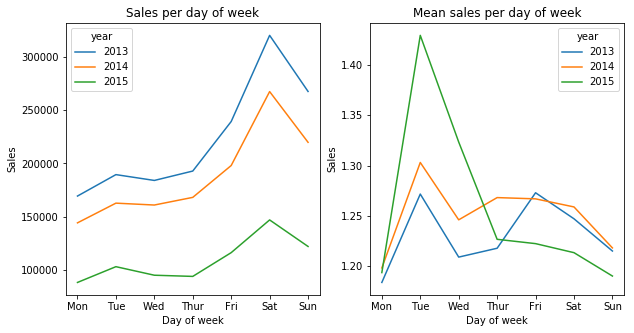

In [22]:
# Annual cumulative sales during week
plt.figure(figsize=(10, 5))

# Sum
ax = plt.subplot(121)
sales_train_eda.groupby(['year', 'dow']).item_cnt_day.sum().unstack(level=0).plot(ax=ax)
plt.title('Sales per day of week')
plt.xlabel('Day of week')
plt.ylabel('Sales')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

# Mean
ax = plt.subplot(122)
sales_train_eda.groupby(['year', 'dow']).item_cnt_day.mean().unstack(level=0).plot(ax=ax)
plt.title('Mean sales per day of week')
plt.xlabel('Day of week')
plt.ylabel('Sales')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

More sales on weekends as expected. Mean sales are biased to tuesday, which may indicate that companies buy large number of specific items during working days.

Also we see that sales decrease with year. sales(2014) < sales(2013), but for 2015 we don't have 2 months in the data. We can nevertheless compare sales for January - October:

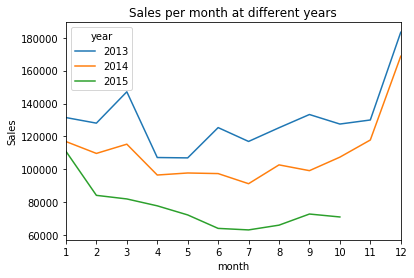

In [23]:
sales_train_eda.groupby(['year', 'month']).item_cnt_day.sum().unstack(level=0).plot()
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.title('Sales per month at different years')
plt.ylabel('Sales');

Now it is clear that sales decrease with years.

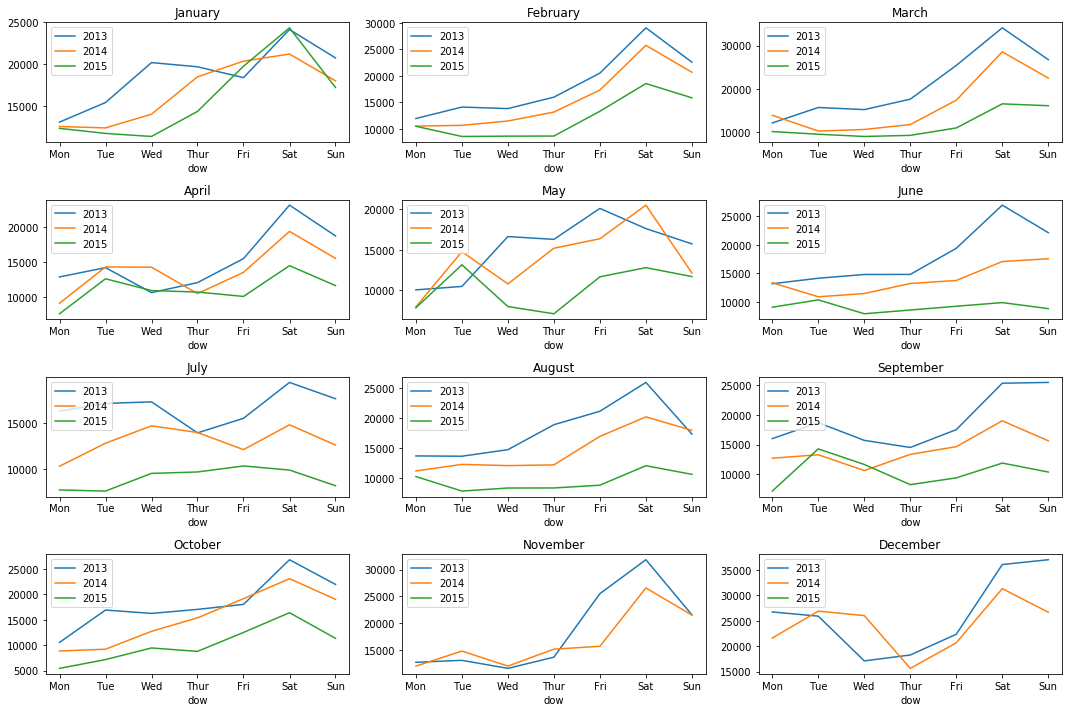

In [24]:
# Monthly cumulative sales during week
month_dow_sales = sales_train_eda.groupby(['year', 'month', 'dow']).item_cnt_day.sum().unstack(level=1)

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
for idx, (month, ax) in enumerate(zip(months, axes.ravel())):
    month_dow_sales.unstack(level=0).loc[:, idx+1].plot(ax=ax)
    ax.set_title(month)
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
    ax.legend(loc='upper left')
fig.tight_layout();

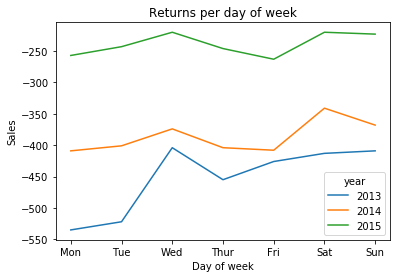

In [25]:
# Annual cumulative returns during week
sales_train_eda[sales_train_eda.item_cnt_day < 0].groupby(['year', 'dow']).item_cnt_day.sum().unstack(level=0).plot()
plt.title('Returns per day of week')
plt.xlabel('Day of week')
plt.ylabel('Sales')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

More returns on monday. Less returns with year since sales decrease.

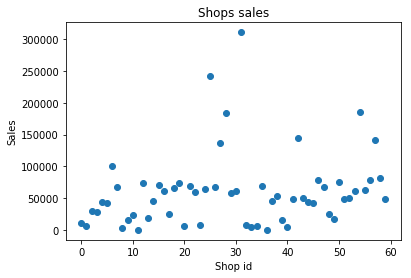

In [26]:
# Distribution of sales at different shops
shop_sum = sales_train_eda.groupby('shop_id').item_cnt_day.sum()
plt.scatter(shop_sum.index, shop_sum.values)
plt.title('Shops sales')
plt.xlabel('Shop id')
plt.ylabel('Sales');

In [27]:
print(f'Shop_id with the larges sales: {shop_sum.idxmax()} ({int(shop_sum.max())} sales)')
print(f'This shop is "{shops.loc[shop_sum.idxmax(), "shop_name"]}"')

Shop_id with the larges sales: 31 (310777 sales)
This shop is "Москва ТЦ "Семеновский""


Moskow.

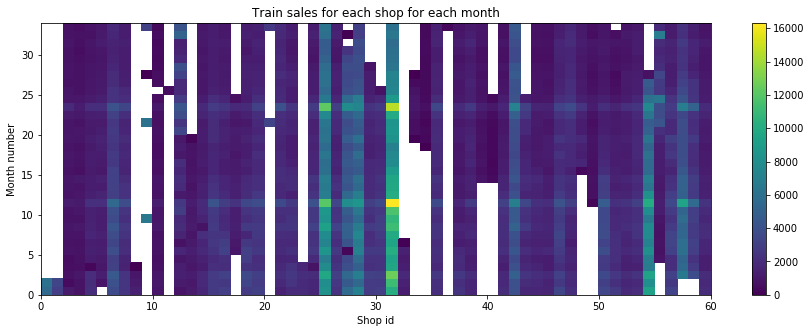

In [28]:
# Now visualize sales for each shop during each month number
shop_sales_per_month_num = sales_train_eda.pivot_table(
    values='item_cnt_day', index='date_block_num', columns='shop_id', aggfunc='sum'
)
plt.figure(figsize=(15, 5))
plt.pcolormesh(shop_sales_per_month_num)
plt.xlabel('Shop id')
plt.ylabel('Month number')
plt.title('Train sales for each shop for each month')
plt.colorbar();

In [29]:
# Some horizontal lines at ~12 and ~24 months are increase of sales during New Year weekends
# We see gaps where there was no sales. Clearly some shops are dead to November 2015
# We can figure that test set does not contain any dead shop
alive_shops = shop_sales_per_month_num.columns[~pd.isnull(shop_sales_per_month_num.loc[33])]
set(sales_test.shop_id) - set(alive_shops)

set()

Test contains only alive shops, so test monthly sales should be non-zero. It also means that we shouldn't add dead shops.

In [30]:
# Train sales at test shops
for shop in set(sales_test.shop_id):
    sales_train_eda[sales_train_eda.shop_id == shop]

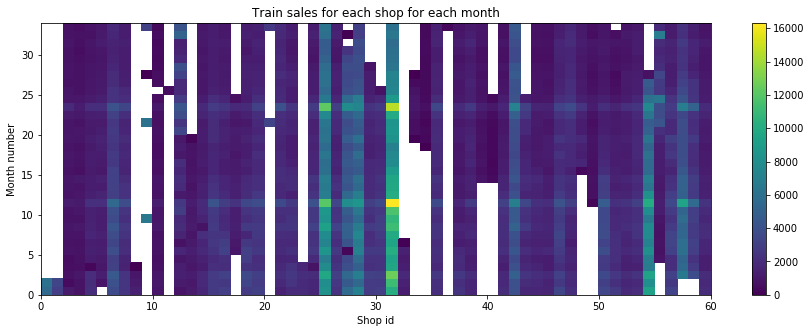

In [31]:
# 
shop_sales_per_month_num = sales_train_eda.pivot_table(
    values='item_cnt_day', index='date_block_num', columns='shop_id', aggfunc='sum'
)
plt.figure(figsize=(15, 5))
plt.pcolormesh(shop_sales_per_month_num)
plt.xlabel('Shop id')
plt.ylabel('Month number')
plt.title('Train sales for each shop for each month')
plt.colorbar();

c:\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


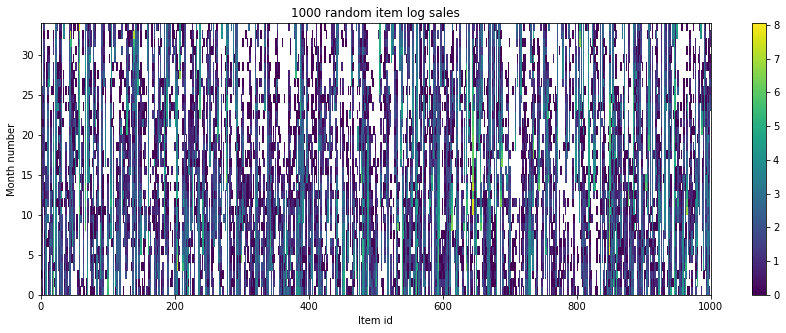

In [32]:
# Item ids are much more sparse. Lets picture 1000 random item_ids
item_sales_per_month_num = sales_train_eda.pivot_table(
    values='item_cnt_day', index='date_block_num', columns='item_id', aggfunc='sum'
)
plt.figure(figsize=(15, 5))
idx = np.random.permutation(item_sales_per_month_num.shape[1])[:1000]
plt.pcolormesh(np.log(item_sales_per_month_num.values[:, idx]))
plt.xlabel('Item id')
plt.ylabel('Month number')
plt.title('1000 random item log sales')
plt.colorbar();

In [33]:
# Find all sales by item_id
item_sum = sales_train_eda.groupby('item_id').item_cnt_day.sum()

In [34]:
# There is outlier, lets examine it
outlier_item_id = item_sum.idxmax()
print(f'Outlier item {outlier_item_id} with sum {item_sum.max()}')
items.loc[outlier_item_id].item_name

Outlier item 20949 with sum 187642.0


'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'

It is a polybag.

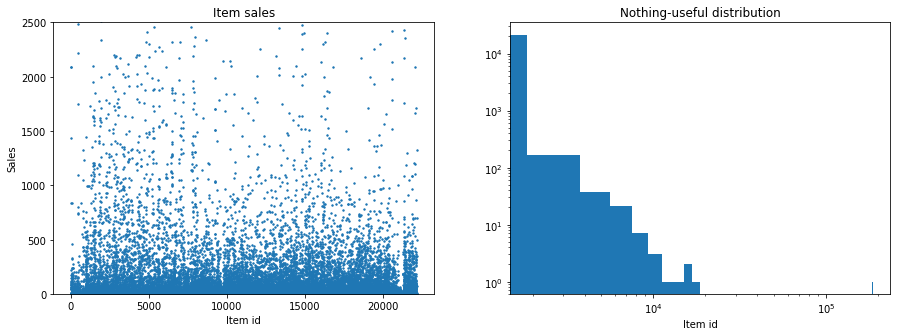

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(item_sum.index, item_sum.values, s=2.)
plt.title('Item sales')
plt.xlabel('Item id')
plt.ylabel('Sales')
plt.ylim(0, 2500)
plt.subplot(122)
plt.hist(item_sum.values, bins=100)
plt.xscale('log')
plt.yscale('log')
plt.title('Nothing-useful distribution')
plt.xlabel('Item id');

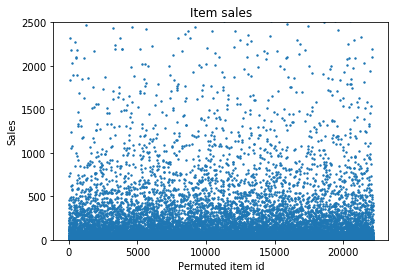

In [36]:
# It seems that there some groups of ids
# We will check this by plotting shuffled item sales
plt.scatter(np.random.permutation(item_sum.index), item_sum.values, s=2.)
plt.ylim(0, 2500)
plt.title('Item sales')
plt.xlabel('Permuted item id')
plt.ylabel('Sales');

Now structure is completely random. Therefore original item id represent some structure.

In [37]:
items.tail()

,item_name,item_category_id
item_id,,
22165,"Ядерный титбит 2 [PC, Цифровая версия]",31
22166,Язык запросов 1С:Предприятия [Цифровая версия],54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49
22168,Яйцо для Little Inu,62
22169,Яйцо дракона (Игра престолов),69


From .head() and .tail() we see that item id sorted by alphabet. What if it is depend on frequency of letters?

In [38]:
item_sum = pd.DataFrame(item_sum)
item_sum.index.name = ''
item_sum['item_id'] = item_sum.index.values
item_sum['First_letter'] = item_sum.index.to_series().map(items.item_name.apply(lambda x: x[0]))

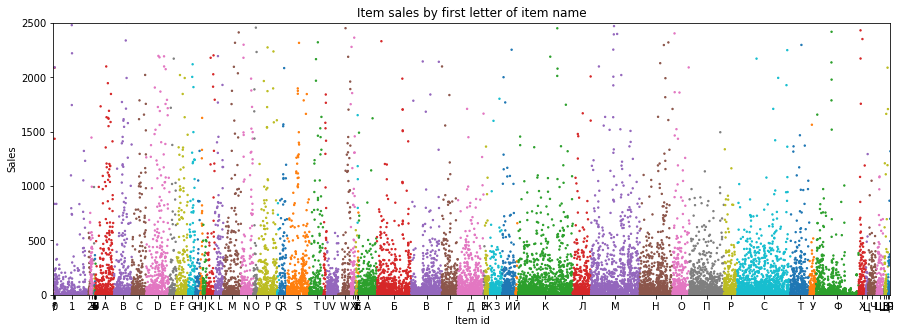

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(111)
colors = it.cycle(['C{}'.format(i) for i in range(0, 10)])
colors = [next(colors) for _ in range(item_sum.First_letter.nunique())]
item_sum['color'] = pd.factorize(item_sum.First_letter)[0]
plt.scatter(item_sum.index, item_sum.item_cnt_day, s=2.,
            c=item_sum.color.apply(lambda x: colors[x]))
labels = item_sum.groupby('First_letter').item_id.mean()
plt.xticks(labels.values, labels.index.values)
plt.title('Item sales by first letter of item name')
plt.xlabel('Item id')
plt.ylabel('Sales')
plt.xlim(0, item_sum.index.max())
plt.ylim(0, 2500);

Well, some of categories indeed correspond to letter frequency, for example [К, М, С] - very frequent russian letters.

In [40]:
# I was interested, why russian 'ф' is so frequent. It appered that it's because of t-shirts
n_tshirts = items.item_name.apply(lambda x: x.lower().startswith('футболка')).sum()
print('Number of t-shirts in data that were written in russian:', n_tshirts)

Number of t-shirts in data that were written in russian: 356


It can be continued forever, so my conclusion is that item_id is just grouped by item name. Thus the text data we have should contain some information on the target.

c:\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


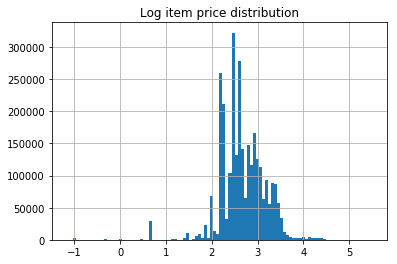

In [41]:
# What about item price column?
np.log10(sales_train_eda.item_price).hist(bins=100);
plt.title('Log item price distribution');

In [42]:
sales_train_eda.item_price.value_counts().head()

299.0    291352
399.0    242603
149.0    218432
199.0    184044
349.0    101461
Name: item_price, dtype: int64

Fun sales prices in [0, 1000] range and 99s indicate that we have retail dataset. Item prices are not presented in the test dataset, but we can use them to encode item_id.

In [43]:
items['mean_price'] = sales_train.groupby('item_id').item_price.mean().astype(np.float32)  # I won't use it later

## Feature extraction and generation

#### Preprocessing from course notebooks

In [44]:
global_features = {}
# Aggregate the data to a monthly level and add rows for missing sales
def preprocess_train():
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales_train['date_block_num'].unique():
        cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
        cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
        grid.append(np.array(list(it.product(*[cur_shops, cur_items, [block_num]])),
                             dtype='int32'))

    # turn the grid into pandas dataframe
    grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

    # get aggregated values for (shop_id, item_id, month)
    gb = sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day':{'target':'sum'}})

    # fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    # join aggregated data to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
    # sort the data
#     all_data.sort_values(['date_block_num','shop_id','item_id'], inplace=True)  # NO SORTING TO DO MAGIC!
    all_data.reset_index(inplace=True, drop=True)
    all_data.target = all_data.target.astype(np.float32)
    return all_data

In [45]:
train = preprocess_train()
train.head()

c:\python36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [46]:
# Let check that number of rows are close
# It confirm our previous observations about test set distribution
print('Number of rows in October 2015 = {}, number of rows in November 2015 = {}'
      ''.format((train.date_block_num == 33).sum(), sales_test.shape[0]))

Number of rows in October 2015 = 238172, number of rows in November 2015 = 214200


#### Item category

In [47]:
FEATURE_ITEM_CATEGORY_ID = 'item_category_id'
def create_item_category(tr, test, new_col=FEATURE_ITEM_CATEGORY_ID):
    tr[new_col] = tr['item_id'].map(items[new_col]).astype(np.int32)
    test[new_col] = test['item_id'].map(items[new_col]).astype(np.int32)

global_features[FEATURE_ITEM_CATEGORY_ID] = create_item_category
create_item_category(train, sales_test)

#### Lagged features

In [48]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
test_index_cols = ['shop_id', 'item_id']
cols_to_rename = ['target']

shift_range = [1, 2, 3, 6, 12]

for month_shift in shift_range:
    train_shift = train[index_cols + cols_to_rename].copy()

    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    train = pd.merge(train, train_shift, on=index_cols, how='left').fillna(0)

    # Test
    test_month_shift = 34 - month_shift
    test_shift = train.loc[train.date_block_num == test_month_shift, test_index_cols + cols_to_rename].copy()
    test_shift = test_shift.rename(columns=foo)
    
    sales_test = pd.merge(sales_test, test_shift, on=test_index_cols, how='left').fillna(0)

lagged_features = [col for col in train.columns if 'lag' in col]
del train_shift, test_shift
gc.collect();

#### Text features

In [49]:
# Sklearn TfidfVectorizer do all necessary preprocessing
# Save mappers to original columns
# I also drop some useless words
train_tf_idf_features = {}
test_tf_idf_features = {}
texts = [item_categories.item_category_name, shops.shop_name, items.item_name]
text_names = ['item_category_id', 'shop_id', 'item_id']

if LOAD:
    print('Loading text features')
    for name in text_names:
        train_tf_idf_features[name] = load_npz(name + '_tf_idf_train.npz')
        test_tf_idf_features[name] = load_npz(name + '_tf_idf_test.npz')
else:
    print('Generate text features')
    stop_words = {
        'item_category_id': ['для'],
        'shop_id': ['тц', 'тк', 'трк', 'трц', 'ii', 'ул', 'пав'],
        'item_id': ['the', 'для', 'of', 'на']
    }
    for name, text in zip(text_names, texts):
        print(f'Extract from {name}')
        vectorizer = TfidfVectorizer(max_features=30, stop_words=stop_words[name])
        tf_idf_feats = vectorizer.fit_transform(text)

        means = np.array(tf_idf_feats.mean(axis=0)).squeeze()
        argsort = means.argsort()
        print('Top frequency words:')
        print(np.array(vectorizer.get_feature_names())[argsort[::-1][:30]])
        print()

        # Create and save
        print('Transform data')
        sparse_text_train = vectorizer.transform(train[name].map(text))
        sparse_text_test = vectorizer.transform(sales_test[name].map(text))
        train_tf_idf_features[name] = sparse_text_train
        test_tf_idf_features[name] = sparse_text_test
        
        print('Save to file')
        save_npz(name + '_tf_idf_train', sparse_text_train)
        save_npz(name + '_tf_idf_test', sparse_text_test)
        print()
print('Success!')

Loading text features
Success!


#### Reduce train size

In [50]:
start_month = 6
reduce_mask = train.date_block_num > start_month
train = train[reduce_mask]
train.reset_index(inplace=True, drop=True)

for name in train_tf_idf_features:
    train_tf_idf_features[name] = train_tf_idf_features[name][reduce_mask.values]

del reduce_mask
gc.collect();

#### Data leakages
I didn't find any leaks that give extraodinary good results.

But I found some magic features.

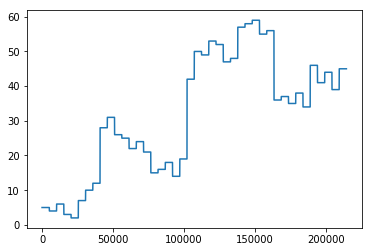

In [51]:
# Test shop_id was not shuffled
sales_test.shop_id.plot();

In [52]:
print(f'How many item_ids in each shop?: {sales_test.item_id.nunique()}')

How many item_ids in each shop?: 5100


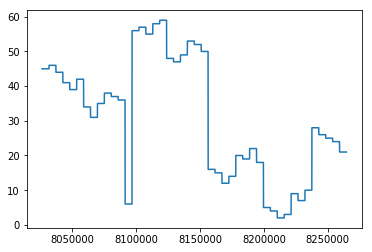

In [53]:
# I had a suspicion that test set was preprocessed just like our extended train set from the course notebooks
train[train.date_block_num == 33].shop_id.plot();

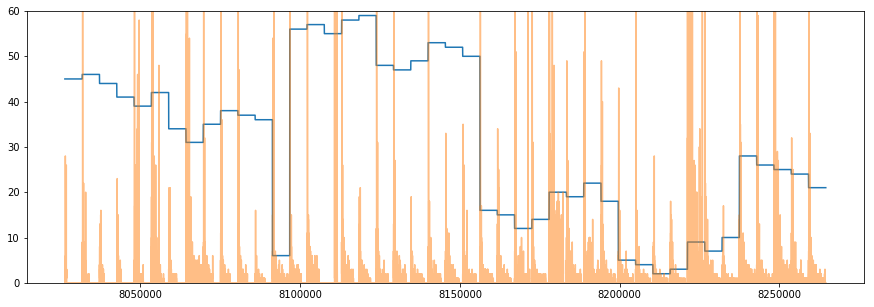

In [54]:
# It structured just like the test! What about target distribution?
plt.figure(figsize=(15, 5))
train[train.date_block_num == 33].shop_id.plot()
train[train.date_block_num == 33].target.plot(alpha=0.5)
plt.ylim(0, 60);

We see target decreases at the beginning of indexes for each new shop in the data. But why? To answer this question we should check how current train was formed in function preprocess_train():
+ we create grid of all possible combinations of shop and item ids that appeared this month
+ we fill the grid with aggregated sales

Important here is how the grid was created - we pick all unique values of shop_id and item_id for certain month and find their combination. This combination is not at random, it takes unique item_ids for each shop_id repeatedly. So, descending structure we see at above figure corresponds to sales at repeated list of item_ids. The list, again, was not shuffled and each its value appear as it shows up in original daily-based train. The later item_id appear for a certain month, the lesser sales it will have. There it is, frequent item_ids come first.

By the way, you wouldn't have seen this if you've sorted data in preprocess_train().

In [55]:
# First magic feature - normalized index within shop_id.
# This feature is clear leak - it reveals ordering of target in the test data
FEATURE_INTERNAL_INDEX = 'internal_index'
def create_first_magic_feature(tr, test, new_col=FEATURE_INTERNAL_INDEX):
    counts_mapping = tr.groupby(['date_block_num', 'shop_id']).shop_id.count()
    counts = pd.Series(list(zip(tr.date_block_num, tr.shop_id))).map(counts_mapping)
    tr[new_col] = (tr.groupby(['date_block_num', 'shop_id']).shop_id.cumcount() / counts).astype(np.float32)

    counts_mapping = test.groupby('shop_id').shop_id.count()
    counts = test.shop_id.map(counts_mapping)
    test[new_col] = (test.groupby('shop_id').shop_id.cumcount() / counts).astype(np.float32)

global_features[FEATURE_INTERNAL_INDEX] = create_first_magic_feature
create_first_magic_feature(train, sales_test)

In [56]:
train[['target', 'internal_index']].corr()

,target,internal_index
target,1.000000,-0.087018
internal_index,-0.087018,1.000000


In [57]:
# Second added feature - normalized frequences of item_id from previous month
# Unlike previous feature, it is not data leak, just another type of encoding
# It is kind of expected distribution of item_id
FEATURE_ITEM_ID_FREQS = 'item_id_freqs'
def create_second_good_feature(tr, test, new_col=FEATURE_ITEM_ID_FREQS):
    tr[new_col] = np.nan
    for month_num in np.unique(tr.date_block_num)[1:]:
        prev_mask = (sales_train.date_block_num == month_num-1)
        prev_mapping = sales_train[prev_mask].item_id.value_counts()

        train_cur_mask = tr.date_block_num == month_num
        
        tr.loc[train_cur_mask, new_col] = tr.loc[train_cur_mask, 'item_id'].map(prev_mapping) / prev_mapping.sum()
    
    mask = sales_train.date_block_num == tr.date_block_num.max()
    full_mapping = sales_train[mask].item_id.value_counts()
    test[new_col] = test['item_id'].map(full_mapping) / full_mapping.sum()

    tr[new_col] = tr[new_col].astype(np.float32)
    test[new_col] = test[new_col].astype(np.float32)

    tr.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

global_features[FEATURE_ITEM_ID_FREQS] = create_second_good_feature
create_second_good_feature(train, sales_test)

In [58]:
train[['target', 'item_id_freqs']].corr()

,target,item_id_freqs
target,1.000000,0.314237
item_id_freqs,0.314237,1.000000


In [59]:
# Lag by 2 month; This feature previosly was frequences grouped by shop but that feature led to huge overfit
FEATURE_ITEM_ID_FREQS2 = 'item_id_freqs2'
def create_third_good_feature(tr, test, new_col=FEATURE_ITEM_ID_FREQS2):
    tr[new_col] = np.nan
    for month_num in np.unique(tr.date_block_num)[2:]:
        prev_mask = (sales_train.date_block_num == month_num-2)
        prev_mapping = sales_train[prev_mask].item_id.value_counts()

        train_cur_mask = tr.date_block_num == month_num
        
        tr.loc[train_cur_mask, new_col] = tr.loc[train_cur_mask, 'item_id'].map(prev_mapping) / prev_mapping.sum()
    
    mask = sales_train.date_block_num == tr.date_block_num.max() - 1
    full_mapping = sales_train[mask].item_id.value_counts()
    test[new_col] = test['item_id'].map(full_mapping) / full_mapping.sum()

    tr[new_col] = tr[new_col].astype(np.float32)
    test[new_col] = test[new_col].astype(np.float32)

    tr.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

global_features[FEATURE_ITEM_ID_FREQS2] = create_third_good_feature
create_third_good_feature(train, sales_test)

In [60]:
train[['target', 'item_id_freqs2']].corr()

,target,item_id_freqs2
target,1.000000,0.272035
item_id_freqs2,0.272035,1.000000


In [61]:
gc.collect()  # even if I create functions to run in local namespace it still does not clean...

249

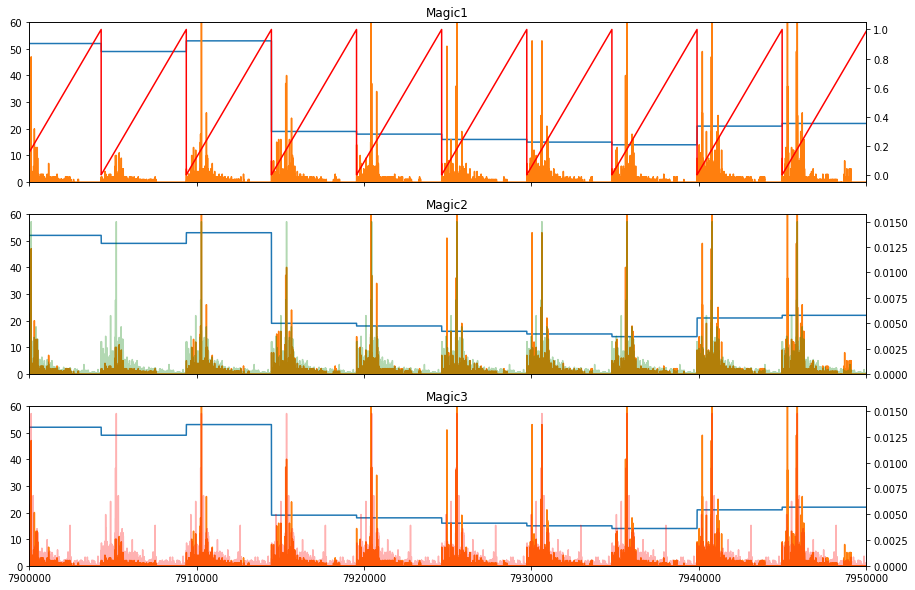

In [62]:
# Fancy all-in one graphic
month_num = 32
xlim = 7.9e6, 7.95e6

plt.figure(figsize=(15, 10))
ax = plt.subplot(311)
train[train.date_block_num == month_num].shop_id.plot(ax=ax)
train[train.date_block_num == month_num].target.plot(ax=ax)
ax.set_ylim(0, 60)
ax_magic = ax.twinx()
train[train.date_block_num == month_num].internal_index.plot(color='red', ax=ax_magic)
ax.set_xlim(xlim)
ax_magic.set_title('Magic1')

ax = plt.subplot(312)
train[train.date_block_num == month_num].shop_id.plot(ax=ax)
train[train.date_block_num == month_num].target.plot(ax=ax)
ax.set_ylim(0, 60)
ax_magic = ax.twinx()
train[train.date_block_num == month_num].item_id_freqs.plot(alpha=0.3, color='green', ax=ax_magic)
ax_magic.set_ylim(0, None)
ax.set_xlim(xlim)
ax_magic.set_title('Magic2')

ax = plt.subplot(313)
train[train.date_block_num == month_num].shop_id.plot(ax=ax)
train[train.date_block_num == month_num].target.plot(ax=ax)
ax.set_ylim(0, 60)
ax_magic = ax.twinx()
train[train.date_block_num == month_num].item_id_freqs2.plot(alpha=0.3, color='red', ax=ax_magic)
ax_magic.set_ylim(0, None)
ax_magic.set_title('Magic3')

ax.set_xlim(xlim);

### Mean encoding
After some testing, expanding mean on all data, lagged by 1 month, showed best performance .

In [63]:
cat_columns = ['shop_id', 'item_id', 'item_category_id']
global_mean = train.target.mean()
current_encoder = ''

In [64]:
def get_enc_name(col):
    return f'{col}_enc'

def get_enc_features():
    global_ = [feat for feat in global_features if 'enc' in feat]
    return global_

def clear_enc_features():
    for feature in get_enc_features():
        if feature in global_features:
            del global_features[feature]

In [65]:
# Using expanding mean
def create_expand_mean_enc(tr, test, col):
    new_col_name = get_enc_name(col)
    tr[new_col_name] = np.nan

    cumsum = tr.groupby(col)['target'].cumsum() - tr['target']
    cumcount = tr.groupby(col)['target'].cumcount()

    expanding_mean = pd.DataFrame({'expand_mean': cumsum / cumcount,
                                   'date_block_num': tr.date_block_num,
                                   col: tr[col]})
    for block_num in np.unique(tr.date_block_num)[1:]:
        cur_mask = tr.date_block_num == block_num
        prev_mask = tr.date_block_num <= block_num - 1
        
        mapping = expanding_mean[prev_mask].groupby(col).expand_mean.last()
        tr.loc[cur_mask, new_col_name] = tr.loc[cur_mask, col].map(mapping)
        
    
    # Fill train with last seen values from train
    prev_mask = tr.date_block_num <= tr.date_block_num.max()
    mapping = expanding_mean[prev_mask].groupby(col).expand_mean.last()
    test[new_col_name] = test[col].map(mapping)
    
    # Downcast
    tr[new_col_name] = tr[new_col_name].astype(np.float32)
    test[new_col_name] = test[new_col_name].astype(np.float32)
    
    # Fill NaNs
    tr[new_col_name].fillna(global_mean, inplace=True) 
    tr[new_col_name].replace(np.inf, global_mean, inplace=True)

    test[new_col_name].fillna(global_mean, inplace=True) 
    test[new_col_name].replace(np.inf, global_mean, inplace=True)

clear_enc_features()
for col in cat_columns:
    global_features[get_enc_name(col)] = partial(create_expand_mean_enc, col=col)
current_encoder = 'expand_mean_enc'

In [66]:
# Global train encoding
print(f'Using {current_encoder}')
for feat in get_enc_features():
    enc_func = global_features[feat]
    enc_func(train, sales_test)

Using expand_mean_enc


## Validation

The problem is an extrapolation task. We want out validation to mimic train/test generation, so for validation fold we will take some month and for training fold all months before it. To preserve sizes of folds, we will do the split for last 3-5 months.

In [67]:
def make_folds(data, last_k_month=3, except_month=(), ret_month=False):
    n_month = data.date_block_num.max()
    
    for k in range(0, n_month):
        # Stop iter
        if last_k_month == 0:
            return
        
        test_month = n_month - k
        
        if test_month in except_month:
            continue
        
        train_mask = data.date_block_num < test_month
        test_mask = data.date_block_num == test_month
        print(f'pick month {test_month} as test; '
              f'train size {train_mask.sum()}, test size {test_mask.sum()}')
        if ret_month:
            yield train_mask, test_mask, test_month
        else:
            yield train_mask, test_mask
        last_k_month -= 1

## Models

### XGBoost

In [68]:
# Used this function for validation and oof predictions
# Some months marked as 'except month', so generator will skip them
# Again validation here is useless, no matter what you do

def gbdt_val_score(model_cls, train_columns, n_folds=5, except_month=(26, 30, 31, 33),
                   verbose_=True, **model_params):
    if verbose_:
        print(f'Use columns: {train_columns}')
        print(f'Feature mean encoder: {current_encoder}')
    
    train_rmse = None
    rmse_train_list = []
    rmse_val_list = []
    feature_importances = []
    predictions = []
    preds_months = []
    for i, (train_mask, test_mask, month) in enumerate(make_folds(train, n_folds, ret_month=True,
                                                                  except_month=except_month)):
        if verbose_:
            print(f'Fold {i+1}/{n_folds}')
        train_fold = train.loc[train_mask].copy()
        test_fold = train.loc[test_mask].copy()
        
        train_target = train_fold['target']
        test_target = test_fold['target']
        
        plt.plot(test_fold.shop_id.values[:50000])
        
        cols_to_drop = list(set(train_fold.columns) - set(train_columns))
        train_fold.drop(cols_to_drop, axis=1, inplace=True)
        test_fold.drop(cols_to_drop, axis=1, inplace=True)
        
        assert set(train_fold.columns) == set(train_columns)
        
        if verbose_:
            print(' start training')
        model = model_cls(**model_params)
        model.fit(train_fold.values, train_target.values)
        
        feature_importances.append(model.feature_importances_)
        
        #train_fold_prediction = model.predict(train_fold.values)
        time.sleep(2)  # some gpu issues
        gc.collect()
        test_fold_prediction = model.predict(test_fold.values)
        predictions.append(test_fold_prediction)
        preds_months.append(np.full(test_fold_prediction.size, month))
        #train_rmse = mean_squared_error(clip_month_counts(train_target.values),
        #                                clip_month_counts(train_fold_prediction)) ** 0.5
        test_rmse = mean_squared_error(clip_month_counts(test_target.values),
                                       clip_month_counts(test_fold_prediction)) ** 0.5
        if verbose_:
            print(f' train fold rmse: {train_rmse}')
            print(f' test fold rmse: {test_rmse}')
        
        #rmse_train_list.append(train_rmse)
        rmse_val_list.append(test_rmse)
        
        if model_cls == xgb.XGBRegressor:
            model.get_booster().__del__()
            
        
        plt.twinx()
        plt.plot(test_fold_prediction[:50000], color='red')
        plt.ylim(0, None)
        plt.show()
    
    #train_rmse = np.mean(rmse_train_list)
    #print('\nTrain mean RMSE: {} (std = {})'.format(train_rmse, np.std(rmse_train_list)))
    val_rmse = np.mean(rmse_val_list)
    print('Validation mean RMSE: {} (std = {})'.format(val_rmse, np.std(rmse_val_list)))
    
    if verbose_:
        print('Feature importances:')
        for col, imp in zip(train_columns, np.mean(feature_importances, axis=0)):
            print(f'{col}: {imp:.4f}')
    
    oof_predictions = pd.DataFrame({'target': np.concatenate(predictions[::-1]),
                                    'date_block_num': np.concatenate(preds_months[::-1])})
    
    return oof_predictions, train_rmse, val_rmse

Use columns: ['internal_index', 'item_id_freqs', 'item_id_freqs2', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12', 'shop_id_enc', 'item_id_enc', 'item_category_id_enc']
Feature mean encoder: expand_mean_enc
pick month 32 as test; train size 7807685, test size 218655
Fold 1/5
 start training
 train fold rmse: None
 test fold rmse: 0.919481143542338


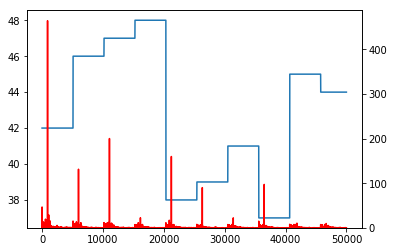

pick month 29 as test; train size 7139972, test size 224288
Fold 2/5
 start training
 train fold rmse: None
 test fold rmse: 0.847825556428503


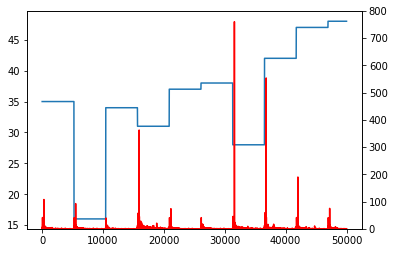

pick month 28 as test; train size 6907520, test size 232452
Fold 3/5
 start training
 train fold rmse: None
 test fold rmse: 0.8239344969981703


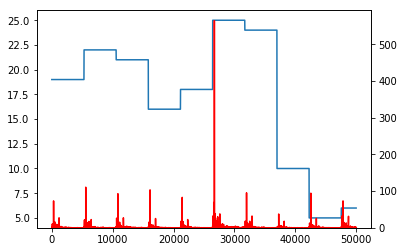

pick month 27 as test; train size 6650148, test size 257372
Fold 4/5
 start training
 train fold rmse: None
 test fold rmse: 0.9134599052445487


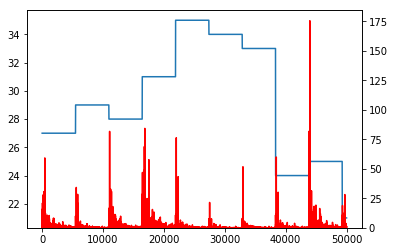

pick month 25 as test; train size 6085885, test size 284491
Fold 5/5
 start training
 train fold rmse: None
 test fold rmse: 0.8191053318320988


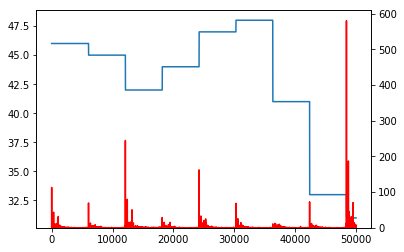

Validation mean RMSE: 0.8647612868091317 (std = 0.043368029960051416)
Feature importances:
internal_index: 0.1553
item_id_freqs: 0.0836
item_id_freqs2: 0.0773
target_lag_1: 0.0546
target_lag_2: 0.0392
target_lag_3: 0.1888
target_lag_6: 0.0726
target_lag_12: 0.0486
shop_id_enc: 0.1488
item_id_enc: 0.0409
item_category_id_enc: 0.0904


In [79]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
train_columns += get_enc_features()

xgboost_params = {
    'max_depth': 6,
    'tree_method': 'gpu_hist'
}

gbdt_val_score(xgb.XGBRegressor, n_folds=5, train_columns=train_columns, **xgboost_params);

In [80]:
gc.collect()

4273

### Results description

Left only some of results. See that large std on results where LB score was best.

5) [> 6 month] xgb with expand enc for item_id. rmse = 0.87225 val rmse = 0.9604 (std 0.047)
    - 'item_category_id', 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12', 'item_id_enc'
6) [> 6 month] xgb, magic feature calculation on last month, not on all train like before. rmse = 0.925582, val rmse = 1.02347 (std=0.289), LB = 0.88870
    - 'item_category_id', 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
7) xgb, magic feature calculation on last month, not on all train like before. rmse = 0.934, val rmse = 0.889899 (std=0.0385), LB = 0.889278
    - 'item_category_id', 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
8) [> 6 month] xgb, magic features calculation on last month, not on all train like before. rmse = 0.93052, val rmse = 0.95838 (std=0.0458),
    - 'item_category_id', 'internal_index', 'item_id_freqs', 'item_id_freqs_shop', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
9) [> 6 month] xgb, magic features calculation on last month, not on all train like before. rmse = 0.9488, val rmse = 1.0081 (std=0.222),
    - 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
10) [> 6 month] xgb, magic feature calculation on last month, not on all train like before. rmse = 0.91763, val rmse = 1.03078 (std=0.261), LB = 0.88734
    - 'item_category_id', 'internal_index', 'item_id_freqs', 'item_id_freqs2', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
11) [> 6 month] xgb, magic for 2 previos month. Lagged expanded mean. rmse = 0.89532, val rmse = 0.98767 (std=0.2255), LB = 0.87966
    - 'internal_index', 'item_id_freqs', 'item_id_freqs2', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12', 'shop_id_enc', 'item_id_enc', 'item_category_id_enc'

#### Hyperparameter tuning 
Tuning via random search. Again useless - validation have too big std. Standard XGBoost with max_depth = 6 performed best on November 2015.

In [61]:
n = 1000
tune_max_depth = np.arange(5, 9)
tune_lr = np.logspace(-2, 0, n)
tune_subsample = np.linspace(0.8, 1., n)
tune_min_child_weight = np.logspace(-1, 3, n)

In [62]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
train_columns += get_enc_features()

Iteration 1/2
Use params: {'max_depth': 5, 'learning_rate': 0.23516428844943485, 'subsample': 0.9209209209209209, 'n_estimators': 150, 'min_child_weight': 1.5602464143663688, 'tree_method': 'gpu_hist'}
pick month 33 as test; train size 8026340, test size 238172


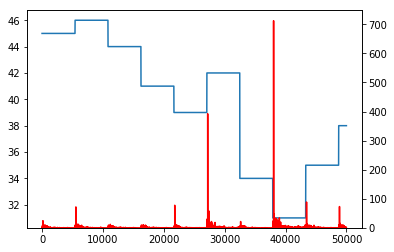

pick month 32 as test; train size 7807685, test size 218655


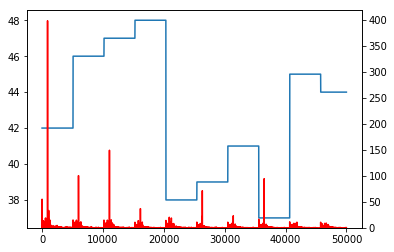

pick month 29 as test; train size 7139972, test size 224288


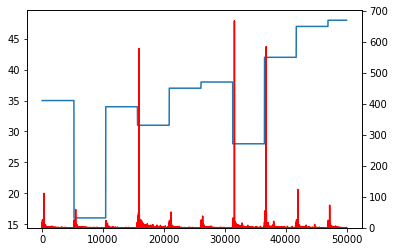

pick month 28 as test; train size 6907520, test size 232452


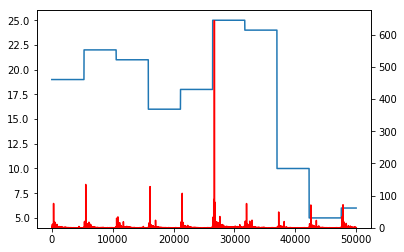

pick month 27 as test; train size 6650148, test size 257372


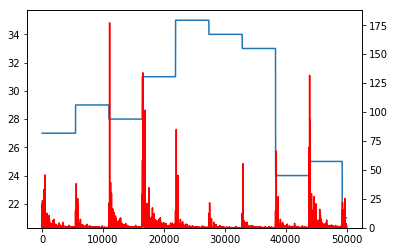

Validation mean RMSE: 0.9056709747448094 (std = 0.04949446620514424)
Iteration 2/2
Use params: {'max_depth': 7, 'learning_rate': 0.09704808877380301, 'subsample': 0.9091091091091091, 'n_estimators': 150, 'min_child_weight': 0.12362095437367689, 'tree_method': 'gpu_hist'}
pick month 33 as test; train size 8026340, test size 238172


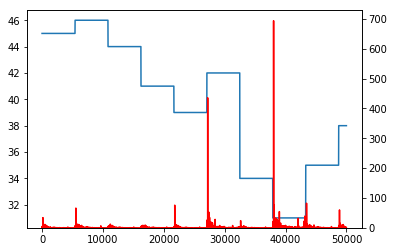

pick month 32 as test; train size 7807685, test size 218655


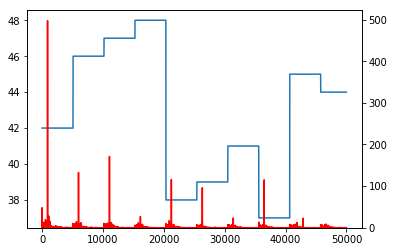

pick month 29 as test; train size 7139972, test size 224288


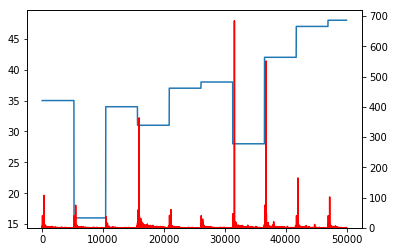

pick month 28 as test; train size 6907520, test size 232452


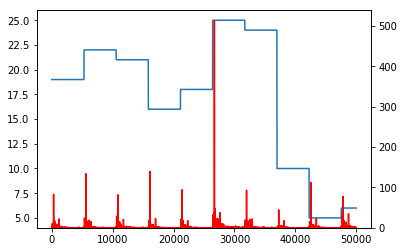

pick month 27 as test; train size 6650148, test size 257372


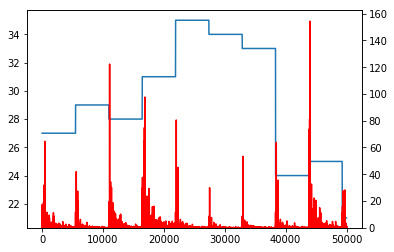

Validation mean RMSE: 0.8939956123099883 (std = 0.05009442779302279)

Best score: 0.8939956123099883
With parameters: {'max_depth': 7, 'learning_rate': 0.09704808877380301, 'subsample': 0.9091091091091091, 'n_estimators': 150, 'min_child_weight': 0.12362095437367689, 'tree_method': 'gpu_hist'}


In [63]:
n_iter = 2
best_params = {}
best_score = 9999

for i in range(n_iter):
    print(f'Iteration {i+1}/{n_iter}')
    xgboost_params = {
        'max_depth': np.random.choice(tune_max_depth),
        'learning_rate': np.random.choice(tune_lr),
        'subsample': np.random.choice(tune_subsample),
        'n_estimators': 150,
        'min_child_weight': np.random.choice(tune_min_child_weight),
        
        'tree_method': 'gpu_hist'
    }
    
    print('Use params:', xgboost_params)
    _, tr_rmse, val_rmse = gbdt_val_score(xgb.XGBRegressor, n_folds=5, train_columns=train_columns, 
                                          verbose_=False, **xgboost_params)
    
    if val_rmse < best_score:
        best_params = xgboost_params
        best_score = val_rmse
print()
print(f'Best score: {best_score}')
print(f'With parameters: {best_params}')

In [71]:
# This tuned parameters work very good on 9/10 month of validation
# Unfortunately, they do not perform good on November 2015, so I will use params which give best LB score
tuned_params = {
    'max_depth': 8,
    'learning_rate': 0.01186,
    'subsample': 0.8244,
    'n_estimators': 150, 
    'min_child_weight': 0.796,
    'tree_method': 'gpu_hist'
}

best_lb_params = {
    'max_depth': 6,
    'tree_method': 'gpu_hist'
}

#### Generate meta-predictions
OOF predictions.

Use columns: ['internal_index', 'item_id_freqs', 'item_id_freqs2', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12', 'shop_id_enc', 'item_id_enc', 'item_category_id_enc']
Feature mean encoder: expand_mean_enc
Following features will be recalculated before training: {'item_id_freqs', 'item_id_freqs2'}
pick month 33 as test; train size 8026340, test size 238172
Fold 1/12
 create local features
 start training
 train fold rmse: 0.8901976179005777
 test fold rmse: 0.9354999506576746


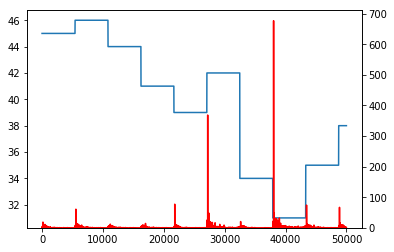

pick month 32 as test; train size 7807685, test size 218655
Fold 2/12
 create local features
 start training
 train fold rmse: 0.8867234889504596
 test fold rmse: 0.919481143542338


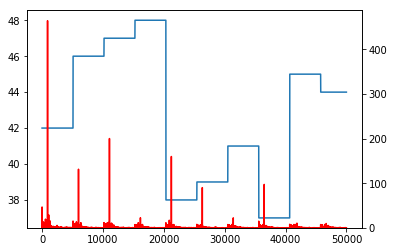

pick month 31 as test; train size 7593149, test size 214536
Fold 3/12
 create local features
 start training
 train fold rmse: 0.8887380051373479
 test fold rmse: 0.8040932989170736


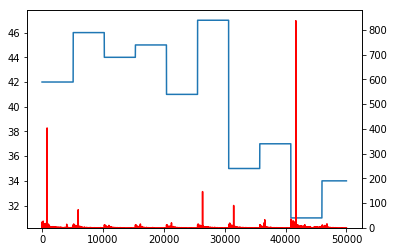

pick month 30 as test; train size 7364260, test size 228889
Fold 4/12
 create local features
 start training
 train fold rmse: 0.8944848394223294
 test fold rmse: 0.7199584504563117


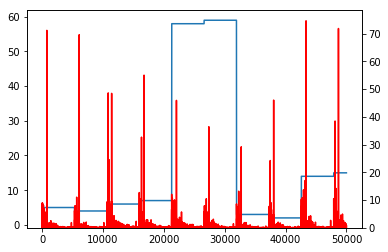

pick month 29 as test; train size 7139972, test size 224288
Fold 5/12
 create local features
 start training
 train fold rmse: 0.8996336562225344
 test fold rmse: 0.848766636804781


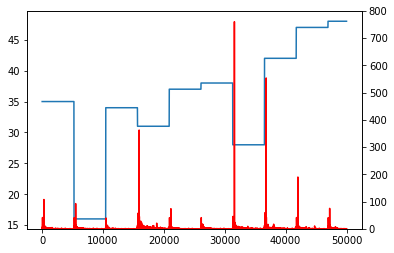

pick month 28 as test; train size 6907520, test size 232452
Fold 6/12
 create local features
 start training
 train fold rmse: 0.9005208283323807
 test fold rmse: 0.8238617905981739


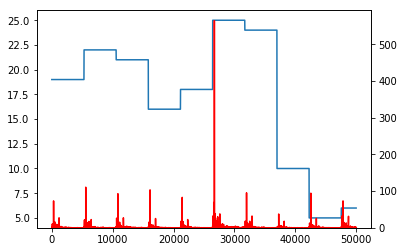

pick month 27 as test; train size 6650148, test size 257372
Fold 7/12
 create local features
 start training
 train fold rmse: 0.899551198902808
 test fold rmse: 0.9134599052445487


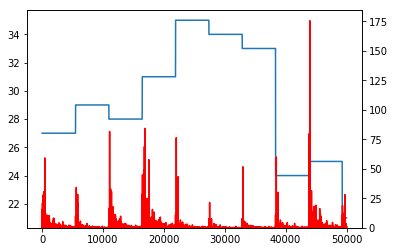

pick month 26 as test; train size 6370376, test size 279772
Fold 8/12
 create local features
 start training
 train fold rmse: 0.9016808060320705
 test fold rmse: 0.8174723549931083


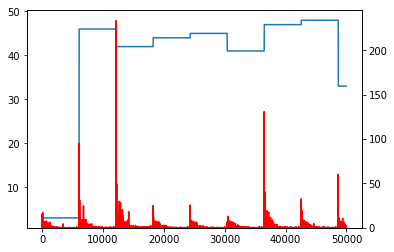

pick month 25 as test; train size 6085885, test size 284491
Fold 9/12
 create local features
 start training
 train fold rmse: 0.9044159054946426
 test fold rmse: 0.8189815805247952


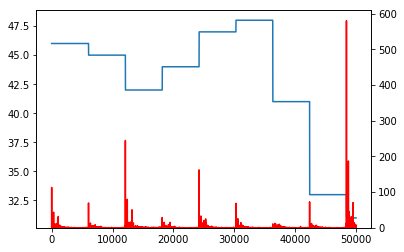

pick month 24 as test; train size 5778935, test size 306950
Fold 10/12
 create local features
 start training
 train fold rmse: 0.9091801464108334
 test fold rmse: 0.8703675942643475


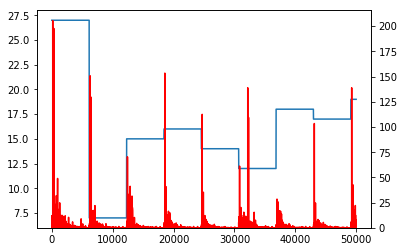

pick month 23 as test; train size 5448685, test size 330250
Fold 11/12
 create local features
 start training
 train fold rmse: 0.8879118970948432
 test fold rmse: 1.1871505022220845


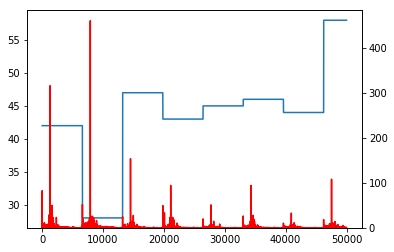

pick month 22 as test; train size 5132585, test size 316100
Fold 12/12
 create local features
 start training
 train fold rmse: 0.8879568052654774
 test fold rmse: 0.9988112834991997


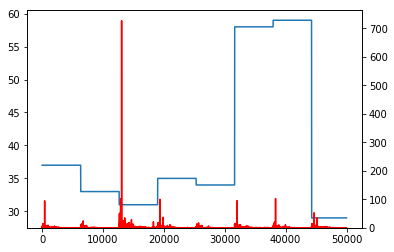


Train mean RMSE: 0.8959162662638587 (std = 0.007233299570976044)
Validation mean RMSE: 0.8881587076437031 (std = 0.11425309331370112)
Feature importances:
internal_index: 0.1559
item_id_freqs: 0.0847
item_id_freqs2: 0.0738
target_lag_1: 0.0546
target_lag_2: 0.0415
target_lag_3: 0.1854
target_lag_6: 0.1516
target_lag_12: 0.0459
shop_id_enc: 0.0927
item_id_enc: 0.0682
item_category_id_enc: 0.0457


In [38]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
train_columns += get_enc_features()


oof_preds, _, _ = gbdt_val_score(xgb.XGBRegressor, n_folds=12, 
                                 train_columns=train_columns,
                                 except_month=(),
                                 **best_lb_params)

In [45]:
mean_squared_error(clip_month_counts(oof_preds.target.values),
                   clip_month_counts(train.target[train.date_block_num > 33 - 12]).values) ** 0.5

0.906889032456446

In [48]:
oof_preds.to_csv('OOF_xgb_basic.csv', index=False)

#### Final predictions
Now on full test.

### train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2'
]
train_columns += lagged_features
train_columns += get_enc_features()

train_columns

In [73]:
model = xgb.XGBRegressor(**best_lb_params)
model.fit(train[train_columns].values, train['target'].values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [74]:
train_prediction = model.predict(train[train_columns].values)
# train_prediction = rounding(train_prediction)
train_rmse = mean_squared_error(clip_month_counts(train['target']),
                                clip_month_counts(train_prediction)) ** 0.5
print('Train rmse:', train_rmse)

Train rmse: 0.8892706561988588


In [75]:
predictions = model.predict(sales_test[train_columns].values)

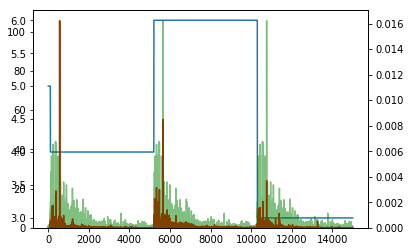

In [76]:
plt.plot(sales_test.shop_id.values[5000:20000])
plt.twinx()
plt.plot(predictions[5000:20000], color='red')
plt.ylim(0, None)
plt.twinx()
plt.plot(sales_test.item_id_freqs.values[5000:20000], color='green', alpha=0.5)
plt.ylim(0, None);

In [77]:
gc.collect()

6700

In [78]:
save_submit_results(sales_test.index, predictions, 'xgb_final')

### Linear regression
For regression I picked all text features and one-hot encoded categorical features. Since it does not fit into memory I had to use dimesionality reduction to 30 features, added standard lagged and magic features.

In [79]:
# Get text features
cols_to_one_hot = ['shop_id', 'item_category_id']
train_text_features = [train_tf_idf_features[name] for name in sorted(train_tf_idf_features)]
test_text_features = [test_tf_idf_features[name] for name in sorted(test_tf_idf_features)]

In [80]:
# One hot encoding
encoders = []
train_one_hot_features = []
test_one_hot_features = []

max_vals = {'shop_id': shops.index.max(),
            'item_category_id': item_categories.index.max(),
            'item_id': items.index.max()}

one_hot = OneHotEncoder(n_values=[max_vals[col]+1 for col in cols_to_one_hot])

train_one_hot = one_hot.fit_transform(train[cols_to_one_hot].values)
train_one_hot_features.append(train_one_hot)

test_one_hot = one_hot.transform(sales_test[cols_to_one_hot].values)
test_one_hot_features.append(test_one_hot)

In [81]:
# Stack everything to sparse format
train_all_sparse_features = train_text_features + [train_one_hot]
test_all_sparse_features = test_text_features + [test_one_hot]
sparse_train = hstack(train_all_sparse_features, format='csr').astype(np.float32)
sparse_test = hstack(test_all_sparse_features, format='csr').astype(np.float32)
gc.collect();

In [82]:
# Reduce dimensions
svd = TruncatedSVD(30)
svd = svd.fit_transform(vstack([sparse_train, sparse_test]))
svd_train = svd[:sparse_train.shape[0]]
svd_test = svd[sparse_train.shape[0]:]
del svd

In [83]:
# This one with scaling
def sparse_data_val_score(model_cls, non_sparse_columns, use_svd=True, n_folds=5, verbose_=True,
                          except_month=(26, 30, 31), scale=True, **model_params):
    
    if verbose_:
        print(f'Use columns: {non_sparse_columns}')    
    
    rmse_train_list = []
    rmse_val_list = []
    predictions = []
    preds_months = []
    for i, (train_mask, test_mask, month) in enumerate(make_folds(train, n_folds,
                                                                  except_month=except_month,
                                                                  ret_month=True)):
        if verbose_:
            print(f'Fold {i+1}/{n_folds}')
        train_fold = train.loc[train_mask].copy()
        test_fold = train.loc[test_mask].copy()
        
        train_target = train_fold['target']
        test_target = test_fold['target']
        
        cols_to_drop = list(set(train_fold.columns) - set(non_sparse_columns))
        train_fold.drop(cols_to_drop, axis=1, inplace=True)
        test_fold.drop(cols_to_drop, axis=1, inplace=True)
        
        assert set(train_fold.columns) == set(non_sparse_columns)
        
        train_fold = train_fold.values
        train_mask = train_mask.values
        train_target = train_target.values
        test_fold = test_fold.values
        test_mask = test_mask.values
        test_target = test_target.values
        
        # Scale
        if scale:
            scaler = MaxAbsScaler()
            train_fold = scaler.fit_transform(train_fold)
            test_fold = scaler.transform(test_fold)
        
        # Concatenate with sparse train
        if use_svd:
            train_fold = np.hstack([train_fold, svd_train[train_mask]])
            test_fold = np.hstack([test_fold, svd_train[test_mask]])
        else:
            train_fold = hstack([train_fold] + [sparse_train[train_mask]])
            test_fold = hstack([test_fold] + [sparse_train[test_mask]])
        
        if verbose_:
            print(' start training')
        model = model_cls(**model_params)
        model.fit(train_fold, train_target)
        
        train_fold_prediction = model.predict(train_fold)
        test_fold_prediction = model.predict(test_fold)
        
        predictions.append(test_fold_prediction)
        preds_months.append(np.full(test_fold_prediction.size, month))
        
        train_rmse = mean_squared_error(clip_month_counts(train_target),
                                        clip_month_counts(train_fold_prediction)) ** 0.5
        test_rmse = mean_squared_error(clip_month_counts(test_target),
                                       clip_month_counts(test_fold_prediction)) ** 0.5
        if verbose_:
            print(f' train fold rmse: {train_rmse}')
            print(f' test fold rmse: {test_rmse}')
        
        rmse_train_list.append(train_rmse)
        rmse_val_list.append(test_rmse)
            
    train_rmse = np.mean(rmse_train_list)
    val_rmse = np.mean(rmse_val_list)
    
    print('\nTrain mean RMSE: {} (std = {})'.format(train_rmse, np.std(rmse_train_list)))
    print('Validation mean RMSE: {} (std = {})'.format(val_rmse, np.std(rmse_val_list)))
    
    oof_predictions = pd.DataFrame({'target': np.concatenate(predictions[::-1]),
                                    'date_block_num': np.concatenate(preds_months[::-1])})
    return oof_predictions, train_rmse, val_rmse

In [96]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
sparse_data_val_score(Ridge, non_sparse_columns=train_columns, use_svd=True);

Use columns: ['internal_index', 'item_id_freqs', 'item_id_freqs2', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12']
pick month 33 as test; train size 8026340, test size 238172
Fold 1/5
 start training
 train fold rmse: 1.0043871725848568
 test fold rmse: 1.0000767678358204
pick month 32 as test; train size 7807685, test size 218655
Fold 2/5
 start training
 train fold rmse: 1.0050374348628857
 test fold rmse: 0.9736794907257432
pick month 29 as test; train size 7139972, test size 224288
Fold 3/5
 start training
 train fold rmse: 1.0228258008409676
 test fold rmse: 0.8575434848336174
pick month 28 as test; train size 6907520, test size 232452
Fold 4/5
 start training
 train fold rmse: 1.0234593978752264
 test fold rmse: 0.9662707197526573
pick month 27 as test; train size 6650148, test size 257372
Fold 5/5
 start training
 train fold rmse: 1.0249610800448423
 test fold rmse: 0.9848726619184822

Train mean RMSE: 1.0161341772417556 (std = 0.0093539372100726

### Results description

Haven't checked this on LB. I guess it perform not good.

1) LinearRegression. Text Feats < 30. One hot shop_id, item_category_id. train rmse = 1.0139, val rmse = 0.9743 (std = 0.053)
    - 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
2) LinearRegression. SVD_30 for sparse features. Text Feats < 30. One hot shop_id, item_category_id. train rmse = 1.02, val rmse = 0.962 (std = 0.05)
    - 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'
3) Ridge with normalize = True. SVD_30 for sparse features. Text Feats < 30. One hot shop_id, item_category_id. train rmse = 1.016, val rmse = 0.958 (std = 0.051)
    - 'internal_index', 'item_id_freqs', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_6', 'target_lag_12'

#### Hyperparameter tuning
Grid search for L2-regularization coefficient.

In [97]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features

In [100]:
n_iter = 10
best_params = {}
best_score = 9999
# tune_alpha = np.logspace(-3, 3, n_iter)
tune_alpha = np.linspace(3, 13, n_iter)  # fine tuuune

for i, alpha in enumerate(tune_alpha):
    print(f'Iteration {i+1}/{n_iter}')
    params = {'alpha': alpha}
    
    print('Use params:', params)
    _, tr_rmse, val_rmse = sparse_data_val_score(Ridge, non_sparse_columns=train_columns,
                                                 use_svd=True, verbose_=False, **params)
    
    if val_rmse < best_score:
        best_params = params
        best_score = val_rmse
print()
print(f'Best score: {best_score}')
print(f'With parameters: {best_params}')

Iteration 1/10
Use params: {'alpha': 3.0}
pick month 33 as test; train size 8026340, test size 238172
pick month 32 as test; train size 7807685, test size 218655
pick month 29 as test; train size 7139972, test size 224288
pick month 28 as test; train size 6907520, test size 232452
pick month 27 as test; train size 6650148, test size 257372

Train mean RMSE: 1.01500030136758 (std = 0.009236077325194592)
Validation mean RMSE: 0.955760067112202 (std = 0.05054202028284109)
Iteration 2/10
Use params: {'alpha': 4.111111111111111}
pick month 33 as test; train size 8026340, test size 238172
pick month 32 as test; train size 7807685, test size 218655
pick month 29 as test; train size 7139972, test size 224288
pick month 28 as test; train size 6907520, test size 232452
pick month 27 as test; train size 6650148, test size 257372

Train mean RMSE: 1.0145834386392087 (std = 0.009228635799857223)
Validation mean RMSE: 0.9556483692682173 (std = 0.05044802393112584)
Iteration 3/10
Use params: {'alpha'

#### Meta-predictions

In [84]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features

params = {'alpha': 4.11}  # Tuned value

oof_preds, _, _ = sparse_data_val_score(Ridge, n_folds=12, non_sparse_columns=train_columns,
                                        use_svd=True, verbose_=False, except_month=(),
                                        **params)

pick month 33 as test; train size 8026340, test size 238172
pick month 32 as test; train size 7807685, test size 218655
pick month 31 as test; train size 7593149, test size 214536
pick month 30 as test; train size 7364260, test size 228889
pick month 29 as test; train size 7139972, test size 224288
pick month 28 as test; train size 6907520, test size 232452
pick month 27 as test; train size 6650148, test size 257372
pick month 26 as test; train size 6370376, test size 279772
pick month 25 as test; train size 6085885, test size 284491
pick month 24 as test; train size 5778935, test size 306950
pick month 23 as test; train size 5448685, test size 330250
pick month 22 as test; train size 5132585, test size 316100

Train mean RMSE: 1.0248580545484198 (std = 0.016413938341026425)
Validation mean RMSE: 0.9666244671958574 (std = 0.12280992546732214)


In [85]:
oof_preds.to_csv('OOF_ridge_tuned.csv', index=False)

#### Test predictions

In [86]:
train_columns = [
    'internal_index',
    'item_id_freqs',
    'item_id_freqs2',
]
train_columns += lagged_features
params = {'alpha': 4.11}  # Tuned value
model = Ridge(**params)

In [87]:
def predict_test(model_cls, model_params, train_columns=train_columns,
                 use_svd=True, scale=True):
    target = train.target.values

    # Scale
    if scale:
        scaler = MaxAbsScaler()
        train_fold = scaler.fit_transform(train[train_columns].values)
        test_fold = scaler.transform(sales_test[train_columns].values)

    # Concatenate with sparse train
    if use_svd:
        train_fold = np.hstack([train_fold, svd_train])
        test_fold = np.hstack([test_fold, svd_test])
    else:
        train_fold = hstack([train_fold] + [sparse_train])
        test_fold = hstack([test_fold] + [sparse_test])
    
    model.fit(train_fold, target)
    train_preds = model.predict(train_fold)
    test_preds = model.predict(test_fold)
    return train_preds, test_preds
ridge_train_preds, ridge_test_preds = predict_test(model, params)

In [88]:
save_submit_results(sales_test.index, ridge_test_preds, 'ridge_final')

### Stacking
Via linear combination. Search coefficient for both predictions separately.

In [89]:
n_oof_month = 12
oof_predictions_files = [
    'OOF_xgb_basic.csv',
    'OOF_ridge_tuned.csv',
]
test_predictions_files = [
    'xgb_final.csv',
    'ridge_final.csv'
]

In [90]:
meta_predictions = [pd.read_csv(filename) for filename in oof_predictions_files]
test_predictions = [pd.read_csv(filename) for filename in test_predictions_files]
meta_target = train.target[train.date_block_num > 33 - n_oof_month]
meta_target.reset_index(inplace=True, drop=True)

In [91]:
meta_predictions = pd.DataFrame({'date_block_num': meta_predictions[0]['date_block_num'],
                                 'target_xgb': meta_predictions[0]['target'],
                                 'target_ridge': meta_predictions[1]['target']})

test_predictions = pd.DataFrame({'target_xgb': test_predictions[0]['item_cnt_month'],
                                 'target_ridge': test_predictions[1]['item_cnt_month']})

In [92]:
best_alpha = 1.
best_beta = 1.
best_rmse = 99999
for alpha in np.linspace(0.5, 1, 50):
    print(alpha)
    for beta in np.linspace(-1, 1, 50):
        preds = meta_predictions['target_xgb'].values * alpha + meta_predictions['target_ridge'] * beta
        rmse = mean_squared_error(clip_month_counts(meta_target.values),
                                  clip_month_counts(preds)) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_beta = beta
print(f'Best alpha: {best_alpha}, best beta: {best_beta} with rmse {best_rmse}')

0.5
0.5102040816326531
0.5204081632653061
0.5306122448979592
0.5408163265306123
0.5510204081632653
0.5612244897959183
0.5714285714285714
0.5816326530612245
0.5918367346938775
0.6020408163265306
0.6122448979591837
0.6224489795918368
0.6326530612244898
0.6428571428571428
0.6530612244897959
0.6632653061224489
0.673469387755102
0.6836734693877551
0.6938775510204082
0.7040816326530612
0.7142857142857143
0.7244897959183674
0.7346938775510203
0.7448979591836735
0.7551020408163265
0.7653061224489796
0.7755102040816326
0.7857142857142857
0.7959183673469388
0.8061224489795917
0.8163265306122449
0.8265306122448979
0.8367346938775511
0.846938775510204
0.8571428571428571
0.8673469387755102
0.8775510204081632
0.8877551020408163
0.8979591836734693
0.9081632653061225
0.9183673469387754
0.9285714285714286
0.9387755102040816
0.9489795918367346
0.9591836734693877
0.9693877551020408
0.9795918367346939
0.9897959183673469
1.0
Best alpha: 0.6632653061224489, best beta: 0.18367346938775508 with rmse 0.8889619

In [93]:
stacked_predictions = (test_predictions['target_xgb'].values * best_alpha
                       + test_predictions['target_ridge'] * best_beta)

In [94]:
# Here we are
save_submit_results(sales_test.index, stacked_predictions, 'stacked_final')

Thanks for reading!